In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
import scipy.ndimage
import cv2
import os

In [2]:
#Importing Data from MATLAB Files
with h5py.File("assignmentImageSegmentation/data/assignmentSegmentBrain.mat", 'r') as mat_file:
    keys = list(mat_file.keys())
    imageData = mat_file[keys[0]][:].T
    imageMask = mat_file[keys[1]][:].T

keys

['imageData', 'imageMask']

In [3]:
q=1.6

Shape of corrupted image: (256, 256)
Shape of binary mask: (256, 256)


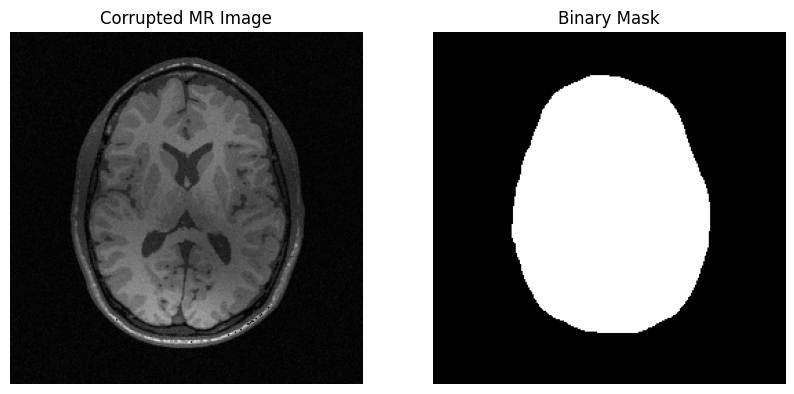

In [4]:
# Extract the corrupted MR image and the binary mask

# Display the shapes of the loaded data
print("Shape of corrupted image:", imageData.shape)
print("Shape of binary mask:", imageMask.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imageData, cmap='gray')
plt.title('Corrupted MR Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imageMask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()


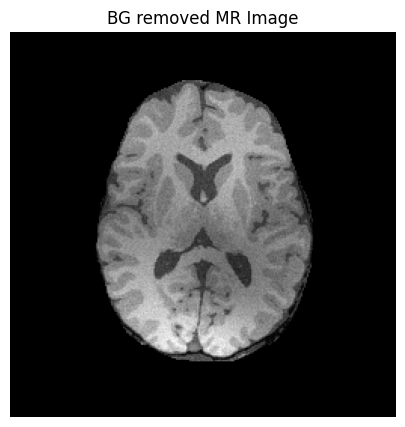

In [5]:
imageData=imageData*imageMask

plt.figure(figsize=(10, 5))
plt.imshow(imageData, cmap='gray')
plt.title('BG removed MR Image')
plt.axis('off')
plt.show()

In [6]:
mask_size = 9
sigma = 2.25

# Generate 1D Gaussian kernel
g_kernel_1d = cv2.getGaussianKernel(mask_size, sigma)

# Create 2D Gaussian kernel by outer product
gaussian_mask = g_kernel_1d @ g_kernel_1d.T

# Normalize to sum to 1
gaussian_mask /= gaussian_mask.sum()

In [7]:
gaussian_mask.shape

(9, 9)

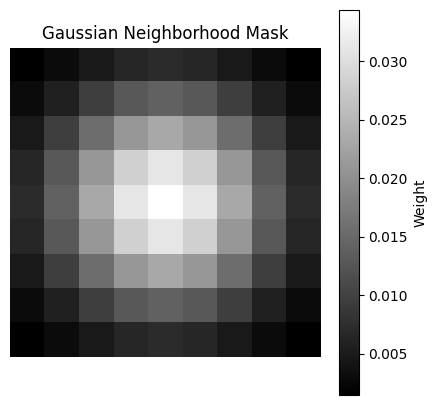

In [8]:
# Display the neighborhood mask
plt.figure(figsize=(5, 5))
plt.imshow(gaussian_mask, cmap="gray")
plt.colorbar(label="Weight")
plt.title("Gaussian Neighborhood Mask")
plt.axis("off")
plt.show()

In [9]:
brain_region_1d= imageData[imageMask > 0].reshape(-1, 1)
num_clusters = 3

# Apply K-means clustering with 3 clusters (WM, GM, CSF)
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
kmeans.fit(brain_region_1d)

# Get initial class means (sorted for consistency: CSF < GM < WM)
initial_means = np.sort(kmeans.cluster_centers_.flatten())

# Display the initial class means
initial_means

array([0.22463489, 0.45355114, 0.63474995], dtype=float32)

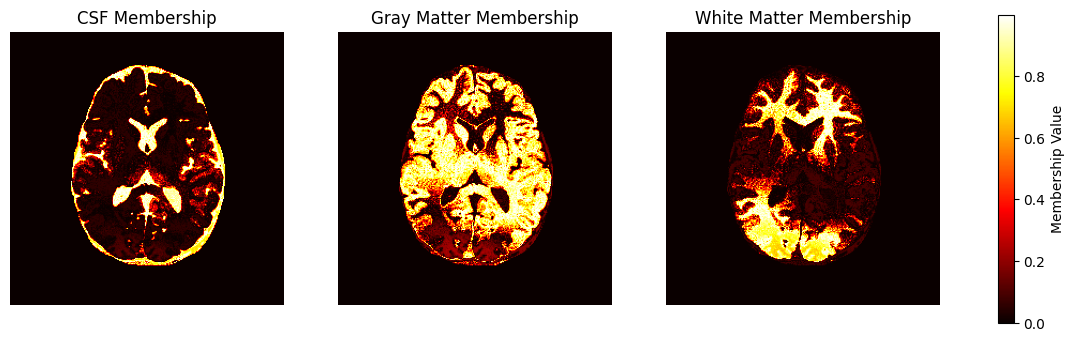

In [10]:
# Compute initial membership values using intensity-based similarity
def initialize_memberships(brain_region_1d, means, q):

    distances = np.abs(brain_region_1d - means)  # Distance from each mean
    inv_distances = distances ** (1 / (1 - q))  
    memberships = inv_distances / np.sum(inv_distances, axis=1, keepdims=True)  # Normalize
    
    return memberships

# Compute initial membership values
initial_memberships = initialize_memberships(brain_region_1d, initial_means, q)

# Reshape back into image format (only within the masked region)
membership_images = [np.zeros_like(imageData) for _ in range(3)]

for i in range(3):
    membership_images[i][imageMask > 0] = initial_memberships[:, i]

# Display membership images for CSF, GM, WM
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["CSF Membership", "Gray Matter Membership", "White Matter Membership"]

for ax, mem_img, title in zip(axes, membership_images, titles):
    im=ax.imshow(mem_img, cmap="hot")
    ax.set_title(title)
    ax.axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label="Membership Value")
plt.show()

In [11]:
initial_memberships.shape

(21282, 3)

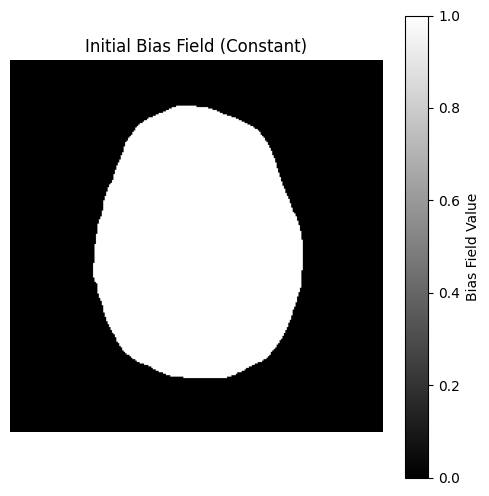

In [12]:
# Initialize the bias field as a constant image (all ones)
initial_bias_field = np.ones_like(imageData)

# Mask out non-brain regions
initial_bias_field[imageMask == 0] = 0

# Display the initialized bias field
plt.figure(figsize=(6, 6))
plt.imshow(initial_bias_field, cmap="gray")
plt.title("Initial Bias Field (Constant)")
plt.axis("off")
plt.colorbar(label="Bias Field Value")
plt.show()

In [13]:
def compute_distances1(imageData,imageMask,bias_field,class_means,gaussian_mask):    
    H, W = imageData.shape  
    K = class_means.shape[0]  
    d = np.zeros((K, H, W)) 
    
    # Compute weighted sums using 2D convolution
    convolve1 = scipy.ndimage.convolve(bias_field, gaussian_mask) 
    convolve2 = scipy.ndimage.convolve(bias_field**2, gaussian_mask)
        
    for k in range(K):
        d[k, : ,:] = ((imageData ** 2) * np.sum(gaussian_mask) - 2* imageData*class_means[k]*convolve1 + (class_means[k]**2)*convolve2)
    
    d = np.maximum(d, 1e-8)     
    return d  # Shape: [H, W, K]

In [14]:
def compute_distances2(imageData,imageMask,bias_field,class_means,gaussian_mask):    
    H, W = imageData.shape  
    K = class_means.shape[0]
    d = np.zeros((K, H, W)) 

    # Compute weighted sums using 2D convolution        
    for k in range(K):
        term= (imageData - class_means[k]*bias_field)**2
        temp =scipy.ndimage.convolve(term, gaussian_mask) 
        d[k, : ,:]=temp
        
    d = np.maximum(d, 1e-8) # Avoid division by zero
    return d

In [15]:
def update_class_means(imageData,imageMask, memberships, bias_field, gaussian_mask, q):
    """Compute updated class means using neighborhood smoothing."""
    updated_means = np.zeros(num_clusters)
    convolve_num = scipy.ndimage.convolve(bias_field,gaussian_mask)
    convolve_den = scipy.ndimage.convolve(bias_field**2,gaussian_mask)
    for k in range(num_clusters):
        num = (memberships[k]**q) *imageData * convolve_num * imageMask
        den = (memberships[k]**q) * convolve_den
        updated_means[k] = np.sum(num) / (np.sum(den))
    return updated_means

# Function to update membership values
def update_memberships(imageData,imageMask, means, bias_field,gaussian_mask,q):

    distances = compute_distances1(imageData, imageMask, bias_field, means, gaussian_mask)
    inv_distances = ((distances) ** (1.0/(1 - q)))  # Compute inverse distances
    memberships = (inv_distances / np.sum(inv_distances, axis=0, keepdims=True))*imageMask  # Normalize
    return memberships

def update_memberships_woD(distances,imageMask,q):

    # distances = compute_distances2(imageData, imageMask, bias_field, means, gaussian_mask)
    inv_distances = ((distances)**(1.0/(1 - q)))  # Compute inverse distances
    memberships = (inv_distances / np.sum(inv_distances, axis=0, keepdims=True))*imageMask  # Normalize
    return memberships

# Function to update bias field using Gaussian smoothing
def update_bias_field(imageData,imageMask, memberships, means, gaussian_mask, q):

    numerator = np.zeros_like(imageData)
    denominator = np.zeros_like(imageData)
    
    for k in range(num_clusters):
        weighted_membership = memberships[k] ** q
        numerator+=weighted_membership * means[k]
        denominator+=weighted_membership * (means[k] ** 2)

    numerator = scipy.ndimage.convolve(imageData * numerator, gaussian_mask)*imageMask
    denominator = scipy.ndimage.convolve(denominator, gaussian_mask)
    
    updated_bias = numerator / (denominator+1e-10)

    return updated_bias


In [16]:
distances1 = compute_distances1(imageData, imageMask, initial_bias_field, initial_means, gaussian_mask)
distances2 = compute_distances2(imageData, imageMask, initial_bias_field, initial_means, gaussian_mask)
print(distances2[0][164][164])
print(distances1[0][164][164])


0.047414250671863556
0.03180716931819916


In [17]:
distances1.shape

(3, 256, 256)

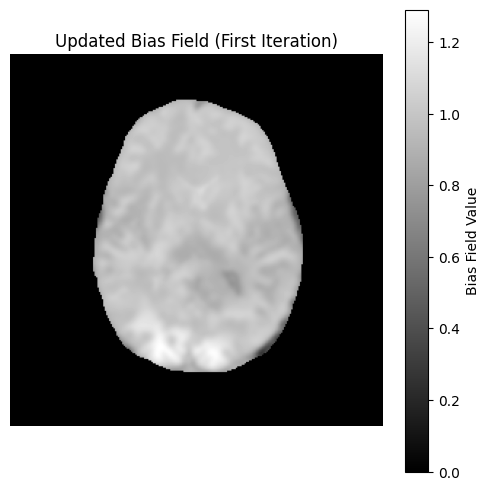

Updated Class Means (First Iteration): [0.22705597 0.45306352 0.63346519]


In [34]:
# Perform first iteration
updated_memberships = update_memberships(imageData,imageMask, initial_means, initial_bias_field,gaussian_mask, q)
updated_means = update_class_means(imageData, imageMask,updated_memberships, initial_bias_field, gaussian_mask, q)
updated_bias_field = update_bias_field(imageData,imageMask,updated_memberships, updated_means, gaussian_mask, q)

# Display updated bias field
plt.figure(figsize=(6, 6))
plt.imshow(updated_bias_field, cmap="gray")
plt.title("Updated Bias Field (First Iteration)")
plt.axis("off")
plt.colorbar(label="Bias Field Value")
plt.show()

# Display updated class means
print("Updated Class Means (First Iteration):", updated_means)

In [35]:
def modified_fcm_segmentation(img, mask,class_means,memberships,bias_field,q,unique, num_clusters=3, num_iterations=40,epsilon=1e-5, w=None):
    """Perform modified fuzzy C-means segmentation with bias field correction."""    
    # Initialize objective function tracking
    objective_vals = []
    
    # Iterative optimization loop
    for iteration in range(num_iterations):
        # Compute distances
        distances = compute_distances1(img, mask, bias_field, class_means, w)
        
        if iteration==0:
            obj_value = np.sum((np.array(memberships) ** q) * distances)
            objective_vals.append(obj_value)
            print(f"Iteration {iteration}/{num_iterations}, Objective: {obj_value:.4f}")
           
        # Update memberships
        memberships = update_memberships_woD(distances,mask, q)

        # Update class means
        class_means = update_class_means(img,mask, memberships, bias_field, w, q)
        if(unique==True):
            class_means[2]=1
        
        # Update bias field
        bias_field = update_bias_field(img, mask,memberships,class_means,w,q)
                
        # Compute objective function value
        obj_value = np.sum((memberships ** q) * distances)
        objective_vals.append(obj_value)

        print(f"Iteration {iteration + 1}/{num_iterations}, Objective: {obj_value:.4f}")

        if abs(obj_value - objective_vals[-2]) < epsilon:
            print(f"Converged at iteration {iteration}/{num_iterations}, Objective: {obj_value:.4f}")
            break
  
    # Compute final outputs
    bias_corrected = np.sum(memberships*class_means[:, None, None], axis=0)  # Bias-corrected image
    residual = img - (bias_corrected * bias_field)  # Residual image
    
    # Extract membership images for each class
    segmented_images = [memberships[k, :, :] for k in range(num_clusters)]
    
    return segmented_images, bias_field, bias_corrected, residual, objective_vals,class_means

In [36]:
def plot_segmentation_results(imageData, bias_corrected, bias_field, residual, segmented_images, imageMask, objective_vals,output_dir):
    """Function to plot and save segmentation results."""
    fig, axes = plt.subplots(2, 4, figsize=(18, 12))

    # Display corrupted image
    axes[0, 0].imshow(imageData, cmap='gray')
    axes[0, 0].set_title("Corrupted Image")
    axes[0, 0].axis("off")
    plt.imsave(os.path.join(output_dir, "corrupted_image.png"), imageData, cmap='gray')
    
    # Display bias-corrected image
    axes[0, 1].imshow(bias_corrected, cmap='gray')
    axes[0, 1].set_title("Bias-Corrected Image")
    axes[0, 1].axis("off")
    plt.imsave(os.path.join(output_dir, "bias_corrected.png"), bias_corrected, cmap='gray')
    
    # Display estimated bias field
    axes[0, 2].imshow(bias_field, cmap='gray')
    axes[0, 2].set_title("Estimated Bias Field")
    axes[0, 2].axis("off")
    plt.imsave(os.path.join(output_dir, "bias_field.png"), bias_field, cmap='gray')
    
    # Display residual image
    axes[0, 3].imshow(residual, cmap='gray')
    axes[0, 3].set_title("Residual Image")
    axes[0, 3].axis("off")
    plt.imsave(os.path.join(output_dir, "residual.png"), residual, cmap='gray')
    
    # Display class membership maps
    for i in range(3):
        axes[1, i].imshow(segmented_images[i], cmap='viridis')
        axes[1, i].set_title(f"Class {i+1} Membership")
        axes[1, i].axis("off")
        plt.imsave(os.path.join(output_dir, f"class_{i+1}_membership.png"), segmented_images[i], cmap='viridis')
    
    axes[1, 3].imshow(np.transpose(segmented_images * imageMask, (1, 2, 0)), cmap="jet")
    axes[1, 3].set_title("Final Segmentation")
    axes[1, 3].axis("off")
    plt.imsave(os.path.join(output_dir, "final_segmentation.png"), np.transpose(segmented_images * imageMask, (1, 2, 0)), cmap="jet")
    
    plt.tight_layout()
    plt.show()
    
    # Plot objective function convergence
    plt.figure(figsize=(8, 5))
    plt.plot(objective_vals, marker="o", linestyle="-", color="b")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Convergence")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "objective_function_convergence.png"))
    plt.show()

Iteration 0/100, Objective: 115.8581
Iteration 1/100, Objective: 96.9279
Iteration 2/100, Objective: 69.0089
Iteration 3/100, Objective: 62.6193
Iteration 4/100, Objective: 59.0189
Iteration 5/100, Objective: 56.3762
Iteration 6/100, Objective: 54.3760
Iteration 7/100, Objective: 52.9158
Iteration 8/100, Objective: 51.9534
Iteration 9/100, Objective: 51.3524
Iteration 10/100, Objective: 50.9522
Iteration 11/100, Objective: 50.6693
Iteration 12/100, Objective: 50.4758
Iteration 13/100, Objective: 50.3399
Iteration 14/100, Objective: 50.2348
Iteration 15/100, Objective: 50.1403
Iteration 16/100, Objective: 50.0466
Iteration 17/100, Objective: 49.9691
Iteration 18/100, Objective: 49.9183
Iteration 19/100, Objective: 49.8858
Iteration 20/100, Objective: 49.8638
Iteration 21/100, Objective: 49.8484
Iteration 22/100, Objective: 49.8387
Iteration 23/100, Objective: 49.8315
Iteration 24/100, Objective: 49.8267
Iteration 25/100, Objective: 49.8237
Iteration 26/100, Objective: 49.8217
Iteration 

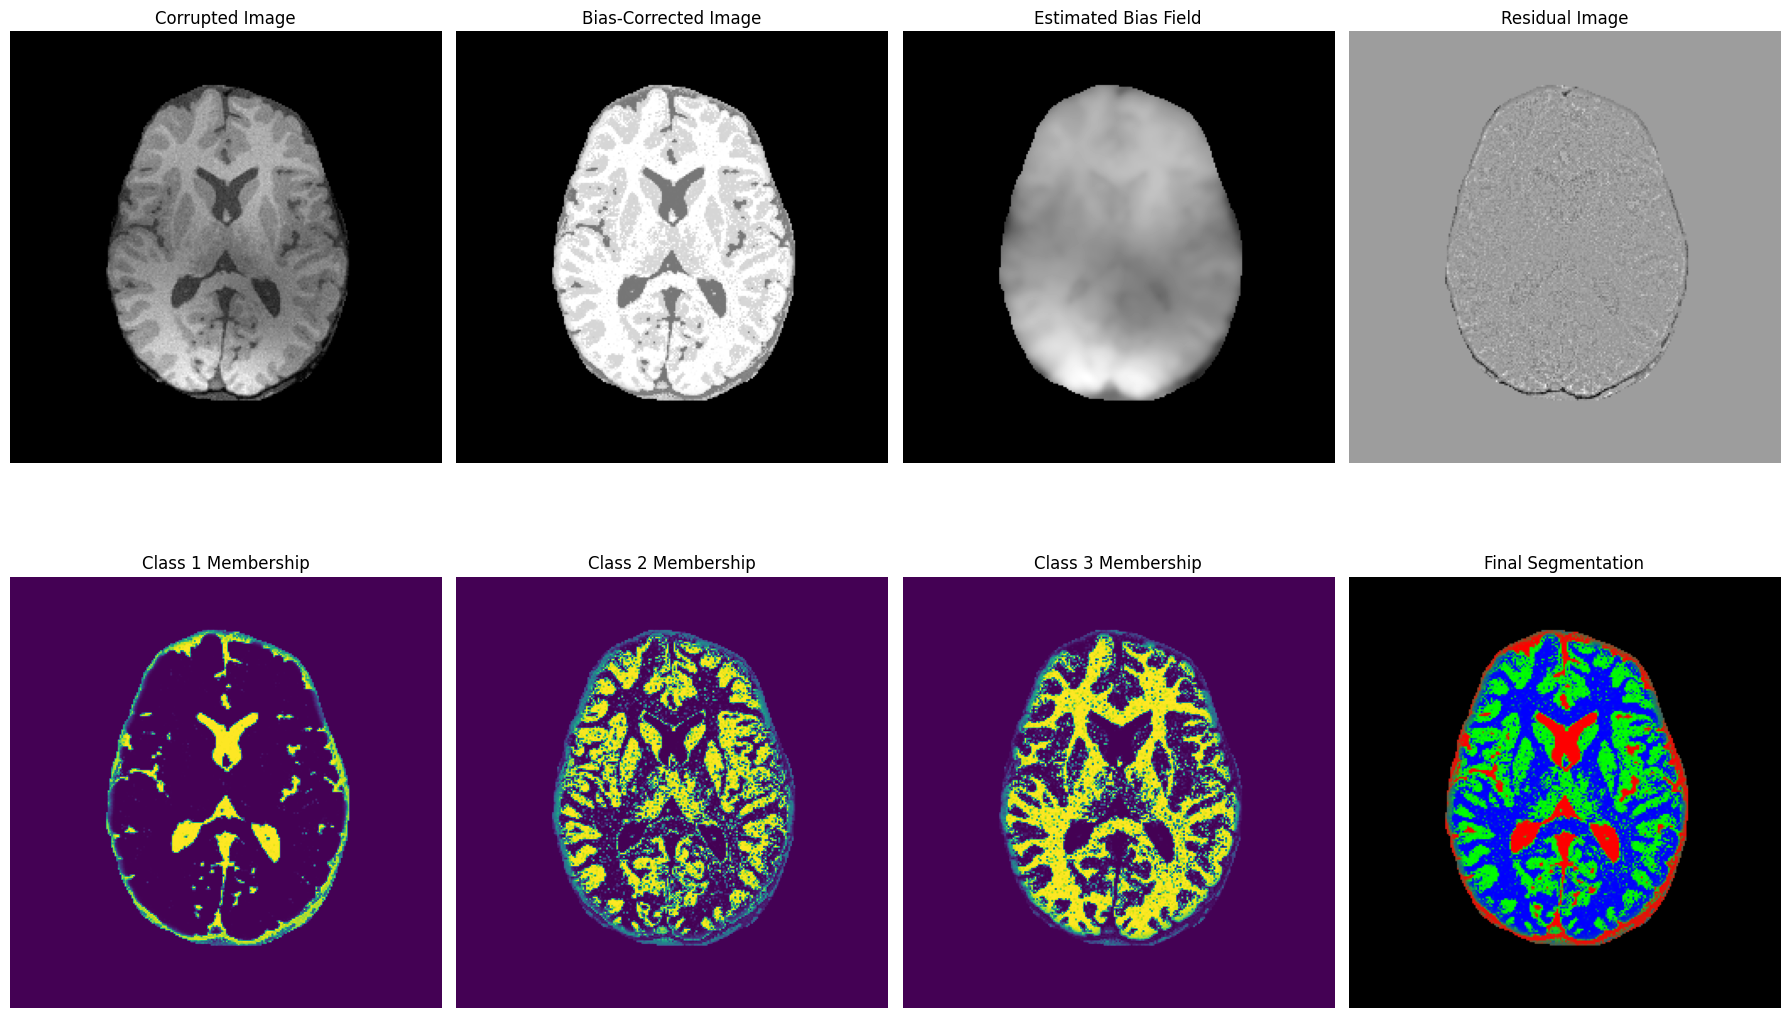

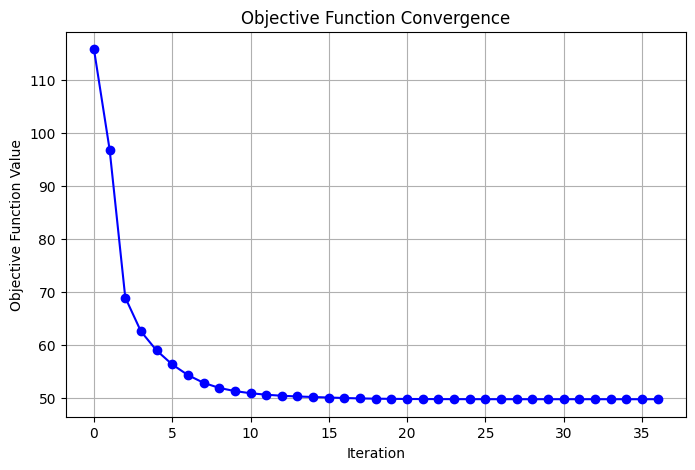

Class Means: [0.26224042 0.4731245  0.56523306]


In [37]:
output_dir = "segmentation_results"
os.makedirs(output_dir, exist_ok=True)
segmented_images, bias_field, bias_corrected, residual, objective_vals,class_means = modified_fcm_segmentation(imageData,imageMask,initial_means,membership_images,initial_bias_field,q=q,unique=False,num_clusters=3,num_iterations=100,w=gaussian_mask)
plot_segmentation_results(imageData, bias_corrected, bias_field, residual, segmented_images, imageMask, objective_vals,output_dir)
print("Class Means:", class_means)

Iteration 0/500, Objective: 769.8196
Iteration 1/500, Objective: 214.0934
Iteration 2/500, Objective: 105.4578
Iteration 3/500, Objective: 91.5525
Iteration 4/500, Objective: 88.5727
Iteration 5/500, Objective: 87.2200
Iteration 6/500, Objective: 86.4361
Iteration 7/500, Objective: 85.8773
Iteration 8/500, Objective: 85.4059
Iteration 9/500, Objective: 84.9646
Iteration 10/500, Objective: 84.5308
Iteration 11/500, Objective: 84.1035
Iteration 12/500, Objective: 83.6960
Iteration 13/500, Objective: 83.3184
Iteration 14/500, Objective: 82.9737
Iteration 15/500, Objective: 82.6544
Iteration 16/500, Objective: 82.3493
Iteration 17/500, Objective: 82.0478
Iteration 18/500, Objective: 81.7388
Iteration 19/500, Objective: 81.4105
Iteration 20/500, Objective: 81.0495
Iteration 21/500, Objective: 80.6341
Iteration 22/500, Objective: 80.1607
Iteration 23/500, Objective: 79.6570
Iteration 24/500, Objective: 79.2675
Iteration 25/500, Objective: 78.9989
Iteration 26/500, Objective: 78.7813
Iteratio

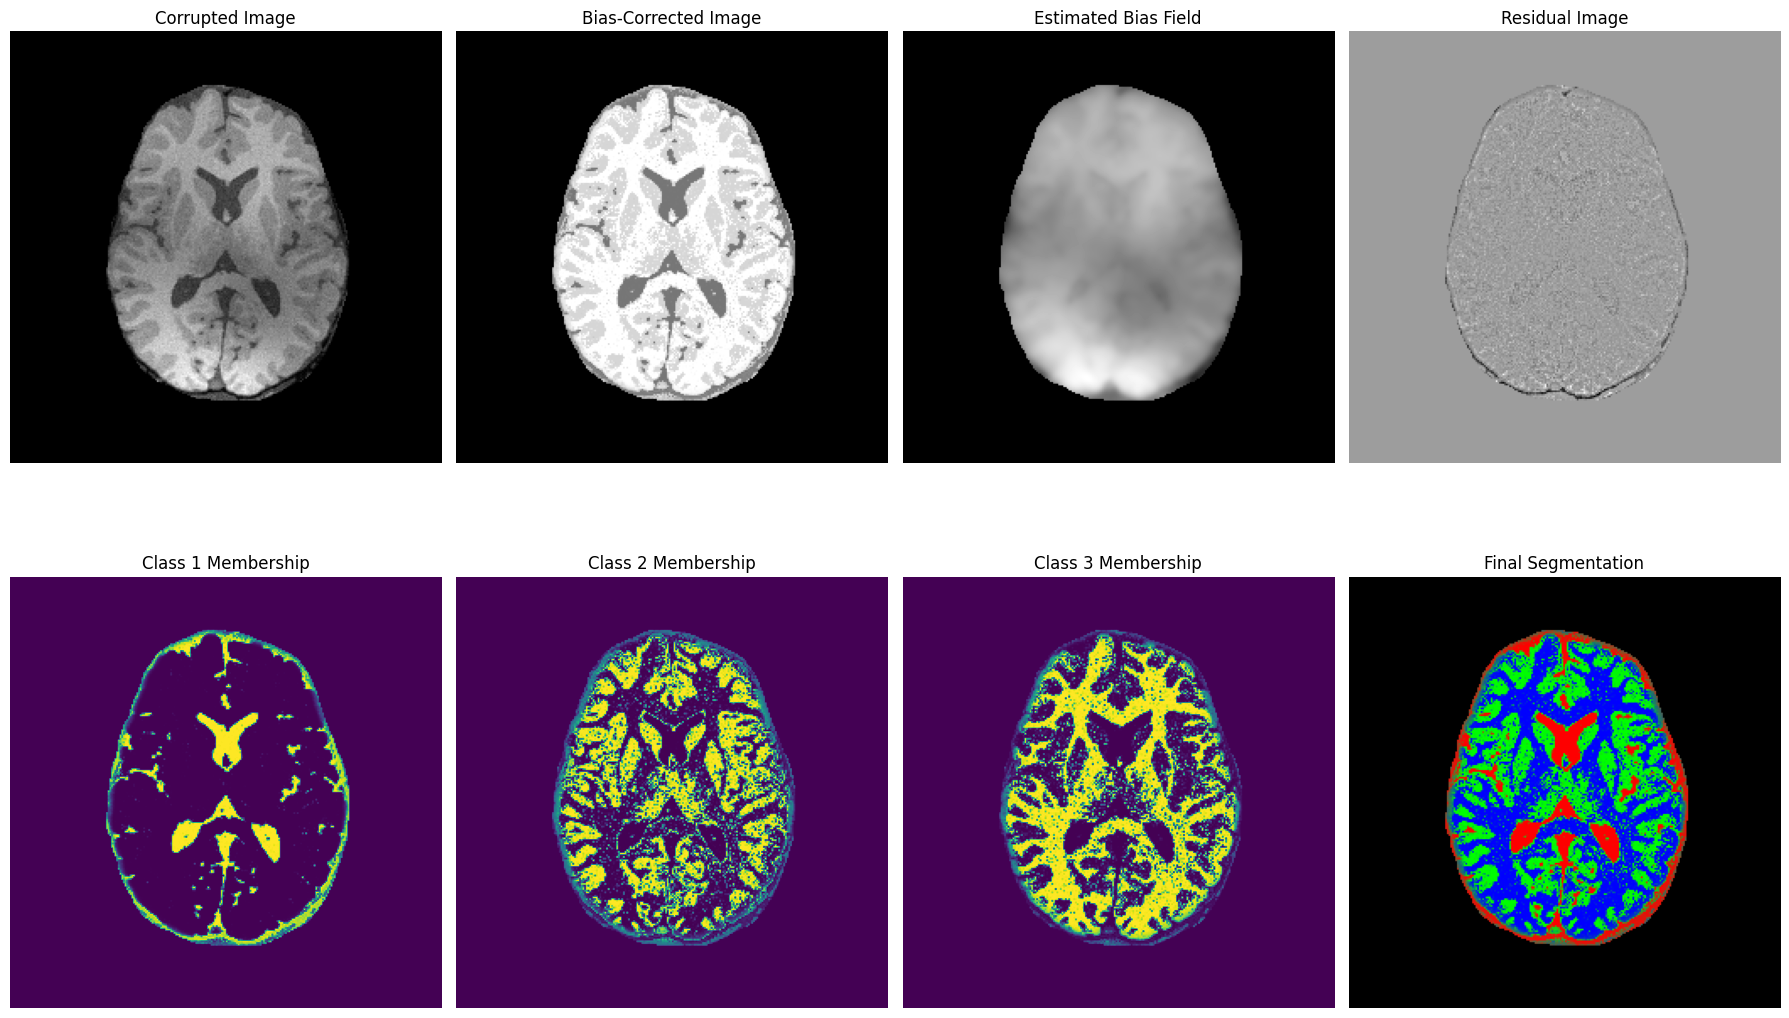

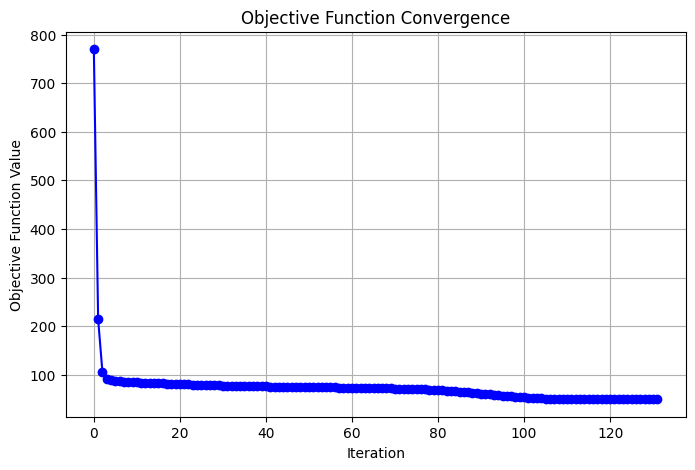

Class Means: [0.46394752 0.83702818 1.        ]


In [38]:
output_dir = "segmentation_results_unique"
os.makedirs(output_dir, exist_ok=True)

initial_means[2]=1
segmented_images, bias_field, bias_corrected, residual, objective_vals,class_means= modified_fcm_segmentation(imageData,imageMask,initial_means,membership_images,initial_bias_field,q=q,unique=True,num_clusters=3,num_iterations=500,w=gaussian_mask)
plot_segmentation_results(imageData, bias_corrected, bias_field, residual, segmented_images, imageMask, objective_vals,output_dir)
print("Class Means:", class_means)